## Learning to Relate


In [2]:
%load_ext autoreload
%autoreload 2
import torch
import cv2
import numpy as np
from kornia.geometry import denormalize_pixel_coordinates
from torch.testing import assert_close
from courtvision.trackers import Tracker, StateIdx
import rerun as rr
from kornia.utils.draw import draw_rectangle
from courtvision.vis import load_timg, plot_3d_points
import cv2
import matplotlib.pyplot as plt
from courtvision.geometry import (
    solve_for_camera_matrix,
    solve_for_projection_matrix,
    denormalize_points,
    solve_for_projection_matrix_v2,
)

In [3]:
from courtvision.geometry import corners_world_3d, convert_corners_to_coords
from courtvision.vis import draw_points, points_to_heat_map
from courtvision.geometry import get_corners_image, get_corners_verital_plane_on_image

pose_points_all = [
    "a_front_left",
    "b_front_right",
    "c_back_left",
    "d_back_right",
    "e_left_near_serve_line",
    "f_right_near_serve_line",
    "g_left_far_serve_line",
    "h_right_far_serve_line",
    "i_center_line_far",
    "j_net_line_left",
    "k_center_line_near",
    "l_net_line_right",
    "m_top_front_left",
    "n_top_front_right",
    "o_top_back_left",
    "p_top_back_right",
    "q_top_net_line_left",
    "r_top_net_line_right",
    "s_top_net_center",
    "t_center_center",
]


pose_points_to_use = [
    "a_front_left",
    "b_front_right",
    "c_back_left",
    "d_back_right",
    #  'e_left_near_serve_line',
    #  'f_right_near_serve_line',
    #  'g_left_far_serve_line',
    #  'h_right_far_serve_line',
    #  'i_center_line_far',
    #  'j_net_line_left',
    #  'k_center_line_near',
    #  'l_net_line_right',
    #  'm_top_front_left',
    #  'n_top_front_right',
    # "o_top_back_left",
    # "p_top_back_right",
    #  "q_top_net_line_left",
    # "r_top_net_line_right",
    # "s_top_net_center",
    # "t_center_center",
]

calibration_poibts_to_use = [
    "a_front_left",
    "b_front_right",
    "c_back_left",
    "d_back_right",
    "e_left_near_serve_line",
    "f_right_near_serve_line",
    "g_left_far_serve_line",
    "h_right_far_serve_line",
    "i_center_line_far",
    "j_net_line_left",
    "k_center_line_near",
    "l_net_line_right",
]

corners_world_3d_calib = corners_world_3d.copy()
corners_world_3d_pose = corners_world_3d.copy()
corners_world_3d_pose_all = corners_world_3d.copy()

corners_image_n = get_corners_image("curated_001/curated_001_frame_0001")
corners_image_other = get_corners_verital_plane_on_image(
    "curated_001/curated_001_frame_0001", plane="both"
)
corners_image_n.update(corners_image_other)

corners_image_n_calib = corners_image_n.copy()
corners_image_n_pose = corners_image_n.copy()


def remove_points(data_points, use_points, set_name):
    for k in list(data_points.keys()):
        if k not in use_points:
            print(f"removing {k} from {set_name}")
            data_points.pop(k)
    return data_points


corners_world_3d_calib = remove_points(
    corners_world_3d_calib,
    calibration_poibts_to_use,
    set_name="world_3d_calib",
)
corners_image_n_calib = remove_points(
    corners_image_n_calib, calibration_poibts_to_use, "image_n_calib"
)

corners_world_3d_pose = remove_points(
    corners_world_3d_pose, pose_points_to_use, "world_3d_pose"
)
corners_image_n_pose = remove_points(
    corners_image_n_pose, pose_points_to_use, "image_n_pose"
)

assert len(set(corners_world_3d_calib.keys()) - set(corners_image_n_calib.keys())) == 0
assert len(set(corners_image_n_calib.keys()) - set(corners_world_3d_calib.keys())) == 0

assert len(set(corners_world_3d_pose.keys()) - set(corners_image_n_pose.keys())) == 0
assert len(set(corners_image_n_pose.keys()) - set(corners_world_3d_pose.keys())) == 0
assert all(
    [
        world_pose == image_pose
        for world_pose, image_pose in zip(
            corners_world_3d_pose.keys(), corners_image_n_pose.keys(), strict=True
        )
    ]
)
assert len(corners_image_n_pose) == len(corners_world_3d_pose)

removing m_top_front_left from world_3d_calib
removing n_top_front_right from world_3d_calib
removing o_top_back_left from world_3d_calib
removing p_top_back_right from world_3d_calib
removing q_top_net_line_left from world_3d_calib
removing r_top_net_line_right from world_3d_calib
removing s_top_net_center from world_3d_calib
removing t_center_center from world_3d_calib
removing m_top_front_left from image_n_calib
removing n_top_front_right from image_n_calib
removing o_top_back_left from image_n_calib
removing p_top_back_right from image_n_calib
removing q_top_net_line_left from image_n_calib
removing r_top_net_line_right from image_n_calib
removing s_top_net_center from image_n_calib
removing t_center_center from image_n_calib
removing e_left_near_serve_line from world_3d_pose
removing f_right_near_serve_line from world_3d_pose
removing g_left_far_serve_line from world_3d_pose
removing h_right_far_serve_line from world_3d_pose
removing i_center_line_far from world_3d_pose
removing j

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>,
 <Figure size 640x480 with 1 Axes>)

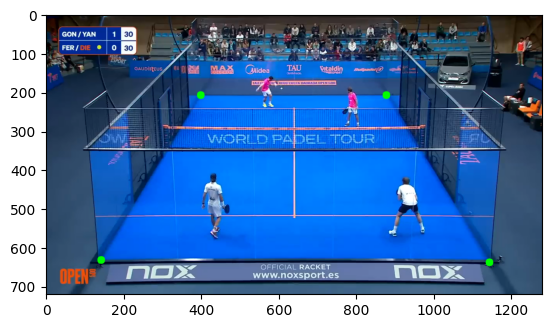

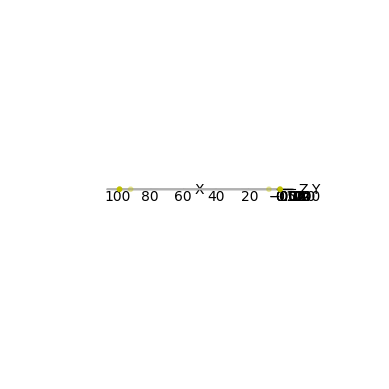

In [4]:
def move_rhs_coordinates(vec):
    tmp = vec.clone()
    return tmp
    #  X -> X
    vec[:, 0] = tmp[:, 0]
    #  Y -> -Z
    vec[:, 1] = -tmp[:, 2]
    #  Z -> Y
    vec[:, 2] = tmp[:, 1]
    return vec


image_size = (1280, 720)
world_points_calib = torch.tensor(
    convert_corners_to_coords(corners_world_3d_calib), dtype=torch.float64
)

world_points_pose = move_rhs_coordinates(
    torch.tensor(convert_corners_to_coords(corners_world_3d_pose), dtype=torch.float64)
)


world_points_pose_all = move_rhs_coordinates(
    torch.tensor(
        convert_corners_to_coords(corners_world_3d_pose_all), dtype=torch.float64
    )
)
# converto from left handed to right handed coordinate system
#  X -> to the right. Y -> downwards  Z -> forward

# world_points_calib[:,0], world_points_calib[:,1], world_points_calib[:,2] = world_points_calib[:,0], -world_points_calib[:,2], world_points_calib[:,1]

# world_points_pose[:,0], world_points_pose[:,1], world_points_pose[:,2] = world_points_pose[:,0], -world_points_pose[:,2], world_points_pose[:,1]

# world_points_pose_all[:,0], world_points_pose_all[:,1], world_points_pose_all[:,2] = world_points_pose_all[:,0], -world_points_pose_all[:,2], world_points_pose_all[:,1]


image_points_calib = torch.tensor(
    denormalize_points(
        corners_image_n_calib, width=image_size[0], height=image_size[1]
    ),
    dtype=torch.float64,
)
image_points_pose = torch.tensor(
    denormalize_points(corners_image_n_pose, width=image_size[0], height=image_size[1]),
    dtype=torch.float64,
)

image_before = (
    load_timg(
        "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
    )
    .squeeze(0)
    .permute(1, 2, 0)
    .numpy()
)
draw_points(
    image=image_before,
    points=image_points_pose,
)
plt.imshow(image_before)
plot_3d_points(
    x=world_points_pose[:, 0].numpy(),
    y=world_points_pose[:, 1].numpy(),
    z=world_points_pose[:, 2].numpy(),
    view_init=(0, 90, 0)
    # labels=list(corners_world_3d.keys())
)

In [6]:
world_points_calib.shape

torch.Size([12, 3])

In [4]:
print(f"{image_points_pose.shape=}")

start_calib_idx = 0
end_calib_idx = 12
camera_matrix, dist_coeffs, reproj_error = solve_for_camera_matrix(
    world_points=world_points_calib[start_calib_idx:end_calib_idx],
    image_points=image_points_calib[start_calib_idx:end_calib_idx],
    image_size=image_size,
    repo_erro_threshold=31.0,
)


cy = 720.0 / 2

cx = 1280.0 / 2
fx = cx / np.tan(0.5 * 0.7)
fy = cy / np.tan(0.5 * 0.7)

# w/(2*tan(camera.fovX())), 0, w/2, 0,
# 0, h/(2*tan(camera.fovY())), h/2, 0,
# 0, 0,   1, 0
# camera_matrix = np.array(
#     [

#             [fx, 0.0, cx],
#             [0.0, fy, cy],
#             [0.0, 0.0, 1.0],

#     ])
print(f"{world_points_pose.numpy().shape=}")
print(f"{image_points_pose.numpy().shape=}")
start_pose_idx = 0
end_pose_idx = 16
projection_matrix, rvec, tvec, reprojected_image_points = solve_for_projection_matrix(
    world_points=world_points_pose.numpy()[start_pose_idx:end_pose_idx],
    image_points=image_points_pose.numpy()[start_pose_idx:end_pose_idx],
    camera_matrix=camera_matrix,
    dist_coeffs=None,
    in_object_coordinate_frame=True,
)

print(f"{np.linalg.norm(tvec)=}")

image_points_pose.shape=torch.Size([4, 2])
repo_erro=6.870878591889668
world_points_pose.numpy().shape=(4, 3)
image_points_pose.numpy().shape=(4, 2)
inliners=None
reprojection_error=12.526527645098005
np.linalg.norm(tvec)=314.6325417396184


In [5]:
from courtvision.geometry import transfrom_points

# reprojected_again = transfrom_points(
#     world_points_pose.numpy()[start_pose_idx:end_pose_idx],
#     projection_matrix,
#     tvec,

# )

reproject_all, _ = cv2.projectPoints(
    world_points_pose_all.numpy(), rvec, tvec, camera_matrix, dist_coeffs
)
reproject_all = reproject_all.reshape(-1, 2)

reproject_fit_set, _ = cv2.projectPoints(
    world_points_pose.numpy(), rvec, tvec, camera_matrix, dist_coeffs
)
reproject_fit_set = reproject_fit_set.reshape(-1, 2)


reprojected_image_points.shape, reproject_all.shape, world_points_pose.numpy().shape, world_points_pose, reproject_all, image_points_pose

((4, 2),
 (20, 2),
 (4, 3),
 tensor([[  0.,   0.,   0.],
         [100.,   0.,   0.],
         [  0., 200.,   0.],
         [100., 200.,   0.]], dtype=torch.float64),
 array([[ 284.01819566,  474.90220616],
        [ 982.99086999,  475.43161885],
        [ 421.20262307,  194.29396455],
        [ 855.76597043,  194.05953519],
        [ 300.7010892 ,  435.59072035],
        [ 969.08604512,  435.84309486],
        [ 410.46034338,  213.41657005],
        [ 866.41957475,  213.21808408],
        [ 638.2190546 ,  213.88356461],
        [ 359.54482347,  308.6249104 ],
        [ 634.63030036,  438.82133629],
        [ 915.97836806,  308.63061318],
        [ 242.42993638,  480.98601911],
        [1021.18653699,  481.72777402],
        [ 407.33794898,  178.00918077],
        [ 867.90667308,  177.72549974],
        [ 353.49247616,  305.97710434],
        [ 921.53255772,  305.98288167],
        [ 637.20688808,  307.46379214],
        [ 637.47505122,  310.06836156]]),
 tensor([[ 142.2222,  632.8889]

In [6]:
world_points_pose_all

tensor([[  0.0000,   0.0000,   0.0000],
        [100.0000,   0.0000,   0.0000],
        [  0.0000, 200.0000,   0.0000],
        [100.0000, 200.0000,   0.0000],
        [  0.0000,  20.0000,   0.0000],
        [100.0000,  20.0000,   0.0000],
        [  0.0000, 180.0000,   0.0000],
        [100.0000, 180.0000,   0.0000],
        [ 50.0000, 180.0000,   0.0000],
        [  0.0000, 100.0000,   0.0000],
        [ 50.0000,  20.0000,   0.0000],
        [100.0000, 100.0000,   0.0000],
        [  0.0000,   0.0000,  30.0000],
        [100.0000,   0.0000,  30.0000],
        [  0.0000, 200.0000,  30.0000],
        [100.0000, 200.0000,  30.0000],
        [  0.0000, 100.0000,   7.8000],
        [100.0000, 100.0000,   7.8000],
        [ 50.0000, 100.0000,   7.8000],
        [ 50.0000, 100.0000,   0.0000]], dtype=torch.float64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 284.0182   474.9022 ]]

 [[ 421.20264  194.29396]]

 [[ 855.766    194.05954]]

 [[ 982.99084  475.4316 ]]

 [[ 242.42993  480.98602]]

 [[ 407.33795  178.00919]]

 [[ 867.9067   177.7255 ]]

 [[1021.1865   481.72778]]]


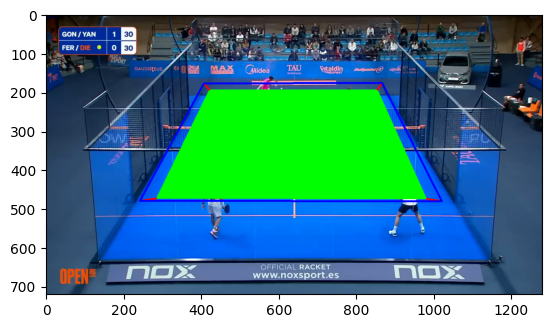

In [7]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)
    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)
    return img


cube_size = 100
court_floor_length = 200
court_floor_width = 100
court_height = 30

# axis = np.float32([[0,0,0],
#                    [0,cube_size,0],
#                    [cube_size,cube_size,0],
#                    [cube_size,0,0],

#                    [0,0,cube_size],
#                    [0,cube_size,cube_size],
#                    [cube_size,cube_size,cube_size],
#                    [cube_size,0,cube_size] ]
# )
axis = np.float32(
    [
        [0, 0, 0],
        [0, court_floor_length, 0],
        [court_floor_width, court_floor_length, 0],
        [court_floor_width, 0, 0],
        [0, 0, court_height],
        [0, court_floor_length, court_height],
        [court_floor_width, court_floor_length, court_height],
        [court_floor_width, 0, court_height],
    ]
)


# Find the rotation and translation vectors.
# ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
# project 3D points to image plane
imgPoints, _ = cv2.projectPoints(
    #    world_points_pose.numpy(),
    axis,
    rvec,
    tvec,
    camera_matrix,
    dist_coeffs,
)
print(imgPoints)
# imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
image = (
    load_timg(
        "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
    )
    .squeeze(0)
    .permute(1, 2, 0)
    .numpy()
)
img = draw(image, axis, imgPoints)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20
4


(tensor([  0., 100.,   0., 100.], dtype=torch.float64),
 tensor([  0.,   0., 200., 200.], dtype=torch.float64),
 tensor([0., 0., 0., 0.], dtype=torch.float64))

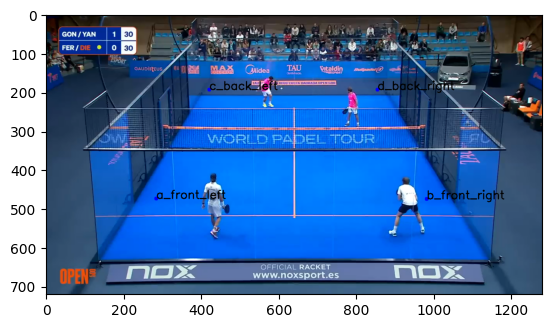

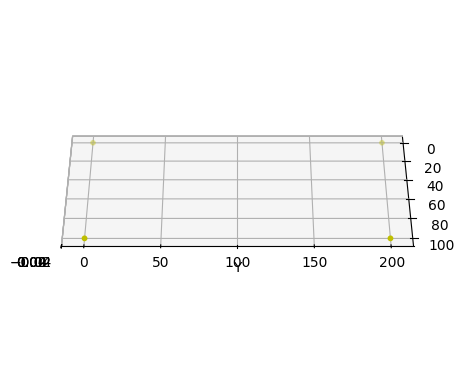

In [8]:
image = (
    load_timg(
        "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
    )
    .squeeze(0)
    .permute(1, 2, 0)
    .numpy()
)
# cv2.circle(image, tuple(image_points[1].numpy().astype(int)), 5, (255, 0, 0), -1)
# image = draw_rectangle(image=image, rectangle=image_points[:2].reshape(-1, 4).unsqueeze(0), fill=True, color=torch.tensor([1, 1, 255])).squeeze(0).permute(1, 2, 0)
import matplotlib.pyplot as plt

print(len(reproject_all))
print(len(image_points_pose))
# pp=points_to_heat_map(corners_image_n, height=image_size[1], width=image_size[0], normalised=True)
# draw_points(image=image, points=pp, color=(255, 0, 0), radius=5, thickness=-1)
# draw_points(
#     image=image,
#     points=image_points_pose[:],
#     color=(0, 255, 0),
#     radius=5,
#     thickness=-1,
#     labels=pose_points_to_use,
# )
draw_points(
    image=image,
    points=reproject_fit_set,
    color=(0, 0, 255),
    radius=5,
    thickness=-1,
    labels=pose_points_to_use,
)
# draw_points(
#     image=image,
#     points=reproject_all,
#     color=(255, 0, 0),
#     radius=5,
#     thickness=-1,
#     labels=pose_points_all,
# )
# print(f"{len(reprojected_image_points)}")
plt.imshow(image)
plot_3d_points(
    x=world_points_pose[:, 0].numpy(),
    y=world_points_pose[:, 1].numpy(),
    z=world_points_pose[:, 2].numpy(),
    view_init=(40, 0, 0)
    # labels=list(corners_world_3d.keys())
)
world_points_pose[:, 0], world_points_pose[:, 1], world_points_pose[:, 2]

tensor([ 142.2222, 1144.8889,  399.1902,  878.7403], dtype=torch.float64)
tensor([632.8889, 638.2222, 208.8045, 208.3930], dtype=torch.float64)
torch.Size([1, 720, 1280])


(tensor(0.0403), tensor(0.))

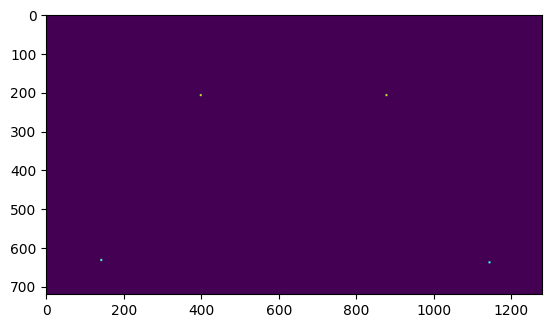

In [190]:
from scipy import ndimage
from torchvision.transforms import GaussianBlur

blur = GaussianBlur(5, sigma=(10.1, 20.0))


def heat_map(
    points: torch.Tensor,
    height: int,
    width: int,
    normalised: bool = True,
    padding: int = 0,
):
    # Calculate the 2D histogram of the points
    # assert max(points[:,0]) <=  width, f"{max(points[:,0])=} is greater than {width=}"
    # assert max(points[:,1]) <=  height, f"{max(points[:,1])=} is greater than {height=}"
    points[:, 0] = torch.clamp(points[:, 0], min=0, max=width - 1)
    points[:, 1] = torch.clamp(points[:, 1], min=0, max=height - 1)
    tmp = torch.zeros(1, height, width)
    rows, cols = points.split(1, dim=1)
    tmp[0, cols.long(), rows.long()] = 1
    return blur(tmp)
    # heatmap, x_edges, y_edges = np.histogram2d(
    #     points[:, 0].detach().numpy(),
    #     points[:, 1].detach().numpy(),
    #     bins=[width, height],
    #     range=[[0, width + padding], [0, height + padding]],
    # )

    # # Smooth the heatmap using a Gaussian filter
    # heatmap = np.float32(ndimage.gaussian_filter(heatmap, sigma=10, radius=300))
    # return heatmap.T, points


print(image_points_pose[:, 0])
print(image_points_pose[:, 1])
heatmap = heat_map(
    image_points_pose, height=image_size[1], width=image_size[0], normalised=True
)
print(heatmap.shape)
plt.imshow(heatmap.squeeze())
heatmap.max(), heatmap.min()

In [191]:
from torch import nn
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)
from kornia.geometry import (
    convert_points_to_homogeneous,
    convert_points_from_homogeneous,
)


def projection_loss(
    *,
    image_court_coordinates_heatmap,
    image_court_coordinates,
    world_court_coordinates,
    projection_matrix,
):

    projected_points_homo = torch.matmul(
        projection_matrix, convert_points_to_homogeneous(world_court_coordinates).T
    )

    projected_points = convert_points_from_homogeneous(projected_points_homo.T)
    # return torch.sum(projected_points - 10.0)
    # projected_points_heatmap = heat_map(
    #     projected_points,
    #     height=720,
    #     width=1280,
    # )

    return torch.mean((projected_points - image_court_coordinates) ** 2)
    # + torch.mean(projected_points_heatmap - image_court_coordinates_heatmap)


class PoseEstimator(nn.Module):
    def __init__(self, world_court_coordinates, image_court_coordinates) -> None:
        super().__init__()
        # x = PX
        self.projection_matrix = nn.Parameter(torch.Tensor(3, 4).double())
        image_court_coordinates_heatmap = heat_map(
            image_court_coordinates,
            height=720,
            width=1280,
        )
        self.image_court_coordinates = torch.tensor(image_court_coordinates)
        self.image_court_coordinates_heatmap = image_court_coordinates_heatmap
        self.world_court_coordinates = torch.tensor(world_court_coordinates)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.projection_matrix)

    def forward(self):
        return projection_loss(
            image_court_coordinates_heatmap=self.image_court_coordinates_heatmap,
            image_court_coordinates=self.image_court_coordinates,
            world_court_coordinates=self.world_court_coordinates,
            projection_matrix=self.projection_matrix,
        )
        # return torch.unsqueeze(self.projection_matrix, dim=0)  # 1x3x3


num_iterations = 10000000
learning_rate = 0.01

model = PoseEstimator(
    world_court_coordinates=world_points_pose,
    image_court_coordinates=image_points_pose,
)

image_coordinates = torch.tensor(image_points_pose).double()  # 1xNx2

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for i in range(num_iterations):
    optimizer.zero_grad()

    loss = model()
    if i % 5000 == 0:
        print(f"{loss=}")
        print(f"{model.projection_matrix=}")
    loss.backward()
    optimizer.step()

loss=tensor(395163.2970, dtype=torch.float64, grad_fn=<MeanBackward0>)
model.projection_matrix=Parameter containing:
tensor([[-0.0148, -0.1229,  0.0260, -0.1039],
        [-0.0744,  0.7079,  0.0335, -1.7268],
        [ 0.5916,  0.7943,  0.5575,  0.5700]], dtype=torch.float64,
       requires_grad=True)


KeyboardInterrupt: 

In [180]:
projection_matrix_v1 = torch.tensor(
    [
        [2.4251e01, 4.9634e00, 4.0768e01, -2.0611e01],
        [2.4438e01, 5.0281e00, 4.0042e01, -2.0106e01],
        [1.9013e-01, 7.7498e-01, 9.8487e-03, 3.5603e-01],
    ],
    dtype=torch.float64,
)
world_court_coordinates = torch.tensor(world_points_pose, dtype=torch.float64)
projected_points_homo = torch.matmul(
    projection_matrix_v1, convert_points_to_homogeneous(world_court_coordinates).T
)

projected_points = convert_points_from_homogeneous(projected_points_homo.T)

In [184]:
torch.mean(projected_points - image_points_pose)

tensor(0.0030, dtype=torch.float64)